In [1]:
import pandas as pd
import numpy as np
import requests
import spacy
import logging
import os 
import re
import json
import datetime
import gzip

# set up the current date and time as one string
current_date = datetime.datetime.now().strftime('%Y-%m-%d')
current_time = datetime.datetime.now().strftime('%H:%M:%S')


#Set up logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    handlers=[
        logging.FileHandler(f"logs/app-{current_date+current_time}.log"),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

# ExploitDB
from pyExploitDb import PyExploitDb
pEdb = PyExploitDb()
pEdb.debug = False
pEdb.openFile()


In [4]:
# Download and unzip NVD CVE data
def download_nvd_cve_data(start_year, end_year, directory):
    base_url = "https://nvd.nist.gov/feeds/json/cve/1.1/nvdcve-1.1-{}.json.zip"
    
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    for year in range(start_year, end_year + 1):
        file_path = os.path.join(directory, f"nvdcve-1.1-{year}.json.zip")
        if os.path.exists(file_path):
            logger.info(f"File {file_path} already exists, skipping download.")
            continue
        
        url = base_url.format(year)
        response = requests.get(url)
        if response.status_code == 200:
            with open(file_path, 'wb') as file:
                file.write(response.content)
            logger.info(f"Downloaded {file_path}")
        else:
            logger.error(f"Failed to download data for year {year}")

# unzip all found files in the directory
def unzip_files(directory):
    import zipfile
    import os
    
    for file in os.listdir(directory):
        if file.endswith(".zip"):
            file_path = os.path.join(directory, file)
            with zipfile.ZipFile(file_path, 'r') as zip_ref:
                zip_ref.extractall(directory)
                logger.info(f"Unzipped {file_path}")
                os.remove(file_path)

# Load NVD CVE data into a DataFrame
def load_nvd_cve_data(directory):
    data = []
    cves_list = []
    for file in os.listdir(directory):
        if file.endswith(".json"):
            file_path = os.path.join(directory, file)
            with open(file_path, 'r') as file:
                data = json.load(file)
                logger.info(f"Loaded {file_path}")
                for index, item in enumerate(data.get("CVE_Items", [])):
                    cve = (
                        item.get("cve", {}).get("CVE_data_meta", {}).get("ID", ""), 
                        item.get("cve", {}).get("description", {}).get("description_data", [{}])[0].get("value", ""),
                        item.get("publishedDate", ""),
                        item.get("lastModifiedDate", ""),
                        item.get("impact", {}).get("baseMetricV3", {}).get("cvssV3", {}).get("version", item.get("impact", {}).get("baseMetricV2", {}).get("cvssV2", {}).get("version", "")),
                        item.get("impact", {}).get("baseMetricV3", {}).get("cvssV3", {}).get("vectorString", item.get("impact", {}).get("baseMetricV2", {}).get("cvssV2", {}).get("vectorString", "")),
                        item.get("impact", {}).get("baseMetricV3", {}).get("cvssV3", {}).get("attackVector", item.get("impact", {}).get("baseMetricV2", {}).get("cvssV2", {}).get("accessVector", "")),
                        item.get("impact", {}).get("baseMetricV3", {}).get("cvssV3", {}).get("attackComplexity", item.get("impact", {}).get("baseMetricV2", {}).get("cvssV2", {}).get("accessComplexity", "")),
                        item.get("impact", {}).get("baseMetricV3", {}).get("cvssV3", {}).get("privilegesRequired", item.get("impact", {}).get("baseMetricV2", {}).get("cvssV2", {}).get("authentication", "")),
                        item.get("impact", {}).get("baseMetricV3", {}).get("cvssV3", {}).get("userInteraction", item.get("impact", {}).get("baseMetricV2", {}).get("cvssV2", {}).get("userInteraction", "")),
                        item.get("impact", {}).get("baseMetricV3", {}).get("cvssV3", {}).get("baseScore", item.get("impact", {}).get("baseMetricV2", {}).get("cvssV2", {}).get("baseScore", "")),
                        item.get("impact", {}).get("baseMetricV3", {}).get("cvssV3", {}).get("baseSeverity", item.get("impact", {}).get("baseMetricV2", {}).get("severity", "")),
                        item.get("impact", {}).get("baseMetricV3", {}).get("exploitabilityScore", item.get("impact", {}).get("baseMetricV2", {}).get("exploitabilityScore", "")),
                        item.get("impact", {}).get("baseMetricV3", {}).get("impactScore", item.get("impact", {}).get("baseMetricV2", {}).get("impactScore", "")),
                        item.get("impact", {}).get("baseMetricV3", {}).get("scope", item.get("impact", {}).get("baseMetricV2", {}).get("scope", "")),
                        item.get("impact", {}).get("baseMetricV3", {}).get("confidentialityImpact", item.get("impact", {}).get("baseMetricV2", {}).get("confidentialityImpact", "")),
                        item.get("impact", {}).get("baseMetricV3", {}).get("integrityImpact", item.get("impact", {}).get("baseMetricV2", {}).get("integrityImpact", "")),
                        item.get("impact", {}).get("baseMetricV3", {}).get("availabilityImpact", item.get("impact", {}).get("baseMetricV2", {}).get("availabilityImpact", "")),
                    )
                    cves_list.append(cve)

    cves_df = pd.DataFrame(cves_list, columns=["cve_id", "description", "published_date", "last_modified_date", "cvss_version", "cvss_vector", "attack_vector", "attack_complexity", "privileges_required", "user_interaction", "base_score", "base_severity", "exploitability_score", "impact_score", "scope", "confidentiality_impact", "integrity_impact", "availability_impact"])
    return cves_df

# Download EPSS scores and ungzip them
def download_epss_scores(date, directory):
    # Download EPSS scores for a given date -1 day
    yesterday = datetime.datetime.strptime(date, "%Y-%m-%d") - datetime.timedelta(days=1)
    yesterday = yesterday.strftime("%Y-%m-%d")
    file_path = os.path.join(directory, f"epss_scores-{yesterday}.csv.gz")
    try:
        if not os.path.exists(file_path):
            logger.info(f"Downloading EPSS scores for date {yesterday}")
            url = f"https://epss.cyentia.com/epss_scores-{yesterday}.csv.gz"
            response = requests.get(url)
            if response.status_code == 200:
                with open(file_path, 'wb') as file:
                    file.write(response.content)
                logger.info(f"Downloaded {file_path}")
        else:
            logger.info(f"File {file_path} already exists, skipping download.")

        logger.info(f"Unzipping {file_path}")
        with gzip.open(file_path, 'rb') as file_in:
            with open(file_path.replace(".gz", ""), 'wb') as file_out:
                file_out.write(file_in.read())
            return file_path.replace(".gz", "")
    except Exception as e:
        logger.error(f"Failed to download EPSS scores for date {date}: {e}")
        return None

# Check on exploitability against exploitdb data
def get_exploitdb_data(cve_id):
    """
    Get the ExploitDB data for a given CVE ID.
    """
    try:
        logger.info(f"Searching ExploitDB data for {cve_id}")
        exploitdb_data = pEdb.searchCve(cve_id)
        if exploitdb_data:
            return pd.Series({
                "exploitdb_id": exploitdb_data.get("id", ""),
                "description": exploitdb_data.get("description", ""),
                "date": exploitdb_data.get("date", ""),
                "date_updated": exploitdb_data.get("date_updated", ""),
                "author": exploitdb_data.get("author", ""),
                "type": exploitdb_data.get("type", ""),
                "platform": exploitdb_data.get("platform", ""),
                "port": exploitdb_data.get("port", ""),
                "url": exploitdb_data.get("url", "")
            })
    except Exception as e:
        print(f"Error getting ExploitDB data for {cve_id}: {e}")
        return pd.Series({
            "exploitdb_id": None,
            "description": None,
            "date": None,
            "author": None,
            "type": None,
            "platform": None,
            "port": None,
            "url": None
        })

# Download KEV data  
def download_known_exploited_vulnerabilities():
    url = "https://www.cisa.gov/sites/default/files/csv/known_exploited_vulnerabilities.csv"
    
    # Download the file and return a DataFrame
    try:
        response = requests.get(url)
        response.raise_for_status()
        file_path = os.path.join("data/download", "known_exploited_vulnerabilities.csv")
        with open(file_path, 'wb') as file:
            file.write(response.content)
        logger.info(f"Downloaded known exploited vulnerabilities to {file_path}")
        return pd.read_csv(file_path)
    except Exception as e:
        print(f"Error loading known exploited vulnerabilities: {e}")
        return None
    
# Enrichment with CISAGOV data

from dotenv import load_dotenv
load_dotenv()

token = os.getenv('GH_TOKEN')
header = {'Authorization': f'token {token}'}
url = f"https://api.github.com/repos/cisagov/vulnrichment"
output = requests.get(url,headers=header)
download_dir = "data/download/CISAGOV"

# function which returns a position in the "metrics" list where the "name" key matches the given value
def get_metric_position_of_other(metrics_list):
    for i, metric in enumerate(metrics_list):
        if "other" in metric:
            return i
    return None

# make output flattened
def flatten_vulnrichment_output(vulnrichment_output):
    flattened_output = {}
    for keyval in vulnrichment_output:
        if isinstance(keyval, dict):
            for k, v in keyval.items():
                flattened_output[k] = v
        else:
            return None
    return flattened_output

def cve_vulnrichment(cve_id):
    parts = cve_id.split("-")
    year = parts[1]  # Example: "2021"
    number = int(parts[2])  # Example: "3493" → 3493
    thousands_group = f"{(number // 1000)}xxx"  # Calculate folder name, e.g., 3xxx

    # Construct URL for the JSON file
    file_path = f"{year}/{thousands_group}/{cve_id}.json"
    file_url = f"{url}/contents/{file_path}"

    try:
        # Get the metadata for the file
        metadata_output = requests.get(file_url,headers=header)
        metadata_output.raise_for_status()
        metadata = metadata_output.json()
        download_url = metadata["download_url"]

        # check if the file already exists
        downloaded_file = os.path.join(download_dir, f"{cve_id}.json")
        if os.path.exists(downloaded_file):
            logger.info(f"File {downloaded_file} already exists, skipping download.")
            # read the file and return the options
            with open(downloaded_file, "r") as file:
                cve = json.load(file)
                if cve.get("cveMetadata", {}).get("state") != "REJECTED":
                    adp_list = cve.get("containers", []).get("adp", [])
                    for i, item in enumerate(adp_list):
                        if "CISA ADP Vulnrichment" in item.get("title"):
                            adp_position = i
                    other = adp_list[adp_position].get("metrics", {})
                    position = get_metric_position_of_other(adp_list[adp_position].get("metrics", {}))
                    logger.info(f"Found positions: {adp_position}, {position}")
                    return other[position].get("other").get("content").get("options")
                else:
                    return [{"Exploitation": None}, {"Automatable": None}, {"Technical Impact": None}]

        # Downloading the JSON file
        logger.info(f"Download URL found, downloading: {download_url}")
        json_response = requests.get(download_url)
        json_response.raise_for_status()
        json_data = json_response.json()

        # Create the download folder if it doesn't exist
        os.makedirs(download_dir, exist_ok=True)

        # Save the file locally
        local_file_path = os.path.join(download_dir, f"{cve_id}.json")
        with open(local_file_path, "w") as f:
            json.dump(json_data, f, indent=4)

        logger.info(f"Downloaded and saved {cve_id} to {local_file_path}")
        if json_data.get("cveMetadata", {}).get("state") != "REJECTED":
            adp_list = json_data.get("containers", []).get("adp", [])
            for i, item in enumerate(adp_list):
                if "CISA ADP Vulnrichment" in item.get("title"):
                    adp_position = i
            other = adp_list[adp_position].get("metrics", {})
            position = get_metric_position_of_other(adp_list[adp_position].get("metrics", {}))
            logger.info(f"Found positions: {adp_position}, {position}")
            return other[position].get("other").get("content").get("options")
        else:
            return [{"Exploitation": None}, {"Automatable": None}, {"Technical Impact": None}]
    
    except requests.exceptions.HTTPError as e:
        logger.error(f"Error downloading {cve_id}: {e}")
        return [{"Exploitation": None}, {"Automatable": None}, {"Technical Impact": None}]

# Update the row with the details from the vulnrichment output
def update_row_with_details(row):
    details = flatten_vulnrichment_output(cve_vulnrichment(row['cve_id']))  # Fetch details for the current row's cve_id
    if not details:
        return 
    for key, value in details.items():
        row[key] = value  # Add each detail as a new column to the row
    return row

In [6]:
download_nvd_cve_data(2004, 2025, "data/download")
unzip_files("data/download")

cves = load_nvd_cve_data("data/download")
# Sort by CVE ID
cves = cves.sort_values(by="cve_id")

cves.to_csv("output/cves_2004-2025.csv", index=False)
today_date = datetime.datetime.now().strftime("%Y-%m-%d")
epss_file = download_epss_scores(today_date, "data/download")
epss_scores = pd.read_csv(epss_file, skiprows=1)
cves_with_epss = pd.merge(cves,epss_scores, left_on="cve_id", right_on="cve", how="left")
cves_with_epss.drop(columns=["cve"], inplace=True)
cves_with_epss.to_csv("output/cves_with_epss_2004-2025.csv", index=False)
kevs = download_known_exploited_vulnerabilities()

# simulate identified vulns outcome
outcome_cves = cves_with_epss.sample(1000)
outcome_cves.drop(columns=["scope", "confidentiality_impact", "integrity_impact", "availability_impact"], inplace=True)
outcome_cves = outcome_cves.apply(update_row_with_details, axis=1)
outcome_cves.to_csv("output/outcome_cves_epss_enriched-20250106.csv", index=False)

2025-01-27 08:14:13,779 - INFO - Downloaded data/download/nvdcve-1.1-2004.json.zip
2025-01-27 08:14:15,352 - INFO - Downloaded data/download/nvdcve-1.1-2005.json.zip
2025-01-27 08:14:17,045 - INFO - Downloaded data/download/nvdcve-1.1-2006.json.zip
2025-01-27 08:14:19,527 - INFO - Downloaded data/download/nvdcve-1.1-2007.json.zip
2025-01-27 08:14:21,791 - INFO - Downloaded data/download/nvdcve-1.1-2008.json.zip
2025-01-27 08:14:23,380 - INFO - Downloaded data/download/nvdcve-1.1-2009.json.zip
2025-01-27 08:14:25,077 - INFO - Downloaded data/download/nvdcve-1.1-2010.json.zip
2025-01-27 08:14:26,759 - INFO - Downloaded data/download/nvdcve-1.1-2011.json.zip
2025-01-27 08:14:28,892 - INFO - Downloaded data/download/nvdcve-1.1-2012.json.zip
2025-01-27 08:14:31,121 - INFO - Downloaded data/download/nvdcve-1.1-2013.json.zip
2025-01-27 08:14:33,039 - INFO - Downloaded data/download/nvdcve-1.1-2014.json.zip
2025-01-27 08:14:34,757 - INFO - Downloaded data/download/nvdcve-1.1-2015.json.zip
2025

Analyse cve descriptions to find relevant Categories and re-assess original CVSS impact
(use spacy.io)

In [8]:
outcome_cves.columns

Index(['cve_id', 'description', 'published_date', 'last_modified_date',
       'cvss_version', 'cvss_vector', 'attack_vector', 'attack_complexity',
       'privileges_required', 'user_interaction', 'base_score',
       'base_severity', 'exploitability_score', 'impact_score', 'epss',
       'percentile', 'Exploitation', 'Automatable', 'Technical Impact'],
      dtype='object')

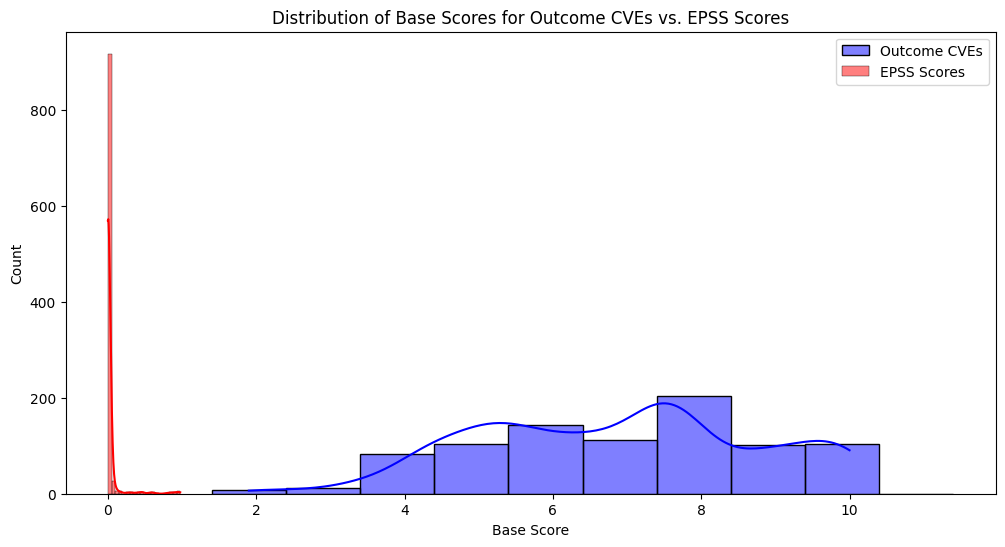

In [9]:
# plot the distribution of the base scores for the outcome cves versus EPSS scores
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.histplot(outcome_cves["base_score"], bins=20, kde=True, color="blue", label="Outcome CVEs")
sns.histplot(outcome_cves["epss"], bins=20, kde=True, color="red", label="EPSS Scores")
plt.title("Distribution of Base Scores for Outcome CVEs vs. EPSS Scores")
plt.xlabel("Base Score")
plt.ylabel("Count")
plt.legend()
plt.savefig("output/base_scores_distribution.png")
plt.show()


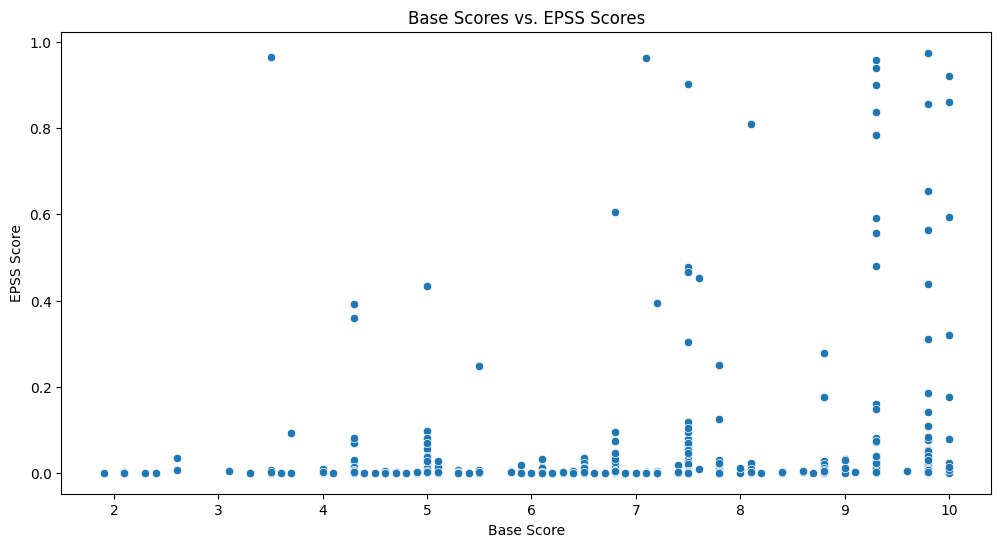

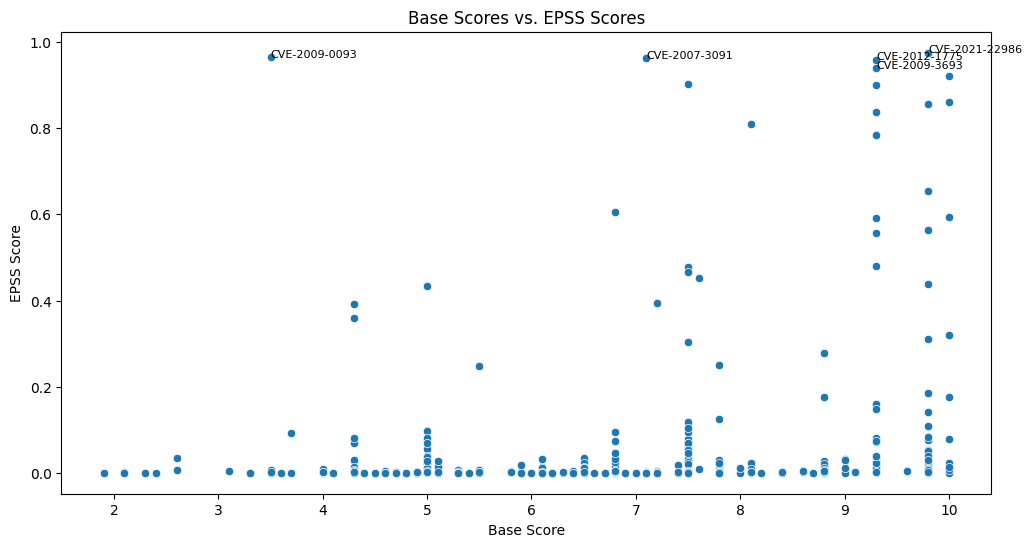

In [18]:
# generate plot with CVE scores in X and EPSS scores in Y
plt.figure(figsize=(12, 6))
sns.scatterplot(x="base_score", y="epss", data=outcome_cves)
plt.title("Base Scores vs. EPSS Scores")
plt.xlabel("Base Score")
plt.ylabel("EPSS Score")
plt.savefig("output/base_vs_epss_scores.png")
plt.show()

# add labels of the CVEs with the highest EPSS scores
highest_epss = outcome_cves.nlargest(5, "epss")
plt.figure(figsize=(12, 6))
sns.scatterplot(x="base_score", y="epss", data=outcome_cves)
for i, row in highest_epss.iterrows():
    plt.text(row["base_score"], row["epss"], row["cve_id"], fontsize=8)
plt.title("Base Scores vs. EPSS Scores")
plt.xlabel("Base Score")
plt.ylabel("EPSS Score")
plt.savefig("output/base_vs_epss_scores_with_labels.png")
plt.show()

In [15]:
# show Bayes' theorem  for the outcome cves with EPSS scores and the known exploited vulnerabilities data 
# calculate the probabilities
total_cves = len(outcome_cves)
total_kevs = len(kevs)
total_epss = len(outcome_cves[outcome_cves["epss"].notnull()])
total_epss_kevs = len(kevs[kevs["cveID"].isin(outcome_cves["cve_id"])])
total_epss_not_kevs = total_epss - total_epss_kevs
total_kevs_not_epss = total_kevs - total_epss_kevs
total_not_epss = total_cves - total_epss
# calculate the probabilities
# Calculate proper probabilities using only the total_cves as the base
p_kevs = total_kevs / total_cves  # P(KEV)
p_epss = total_epss / total_cves  # P(EPSS)
p_kevs_and_epss = total_epss_kevs / total_cves  # P(KEV ∩ EPSS)
p_kevs_given_epss = p_kevs_and_epss / p_epss if p_epss > 0 else 0  # P(KEV|EPSS)
p_epss_given_kevs = p_kevs_and_epss / p_kevs if p_kevs > 0 else 0  # P(EPSS|KEV)
p_not_epss = 1 - p_epss  # P(not EPSS)
p_kevs_and_not_epss = total_kevs_not_epss / total_cves  # P(KEV ∩ not EPSS)
p_kevs_given_not_epss = p_kevs_and_not_epss / p_not_epss if p_not_epss > 0 else 0  # P(KEV|not EPSS)
p_not_epss_given_kevs = 1 - p_epss_given_kevs  # P(not EPSS|KEV)
# print the probabilities
print(f"Total CVEs: {total_cves}")
print(f"Total KEVs: {total_kevs}")
print(f"Total EPSS: {total_epss}")
print(f"Total EPSS KEVs: {total_epss_kevs}")
print(f"Total EPSS not KEVs: {total_epss_not_kevs}")
print(f"Total KEVs not EPSS: {total_kevs_not_epss}")
print(f"Total not EPSS: {total_not_epss}")
print(f"Probability of KEVs: {p_kevs}")
print(f"Probability of EPSS: {p_epss}")
print(f"Probability of KEVs and EPSS: {p_kevs_and_epss}")
print(f"Probability of KEVs given EPSS: {p_kevs_given_epss}")
print(f"Probability of EPSS given KEVs: {p_epss_given_kevs}")
print(f"Probability of KEVs and not EPSS: {p_kevs_and_not_epss}")
print(f"Probability of not EPSS: {p_not_epss}")
print(f"Probability of KEVs given not EPSS: {p_kevs_given_not_epss}")
print(f"Probability of not EPSS given KEVs: {p_not_epss_given_kevs}")


Total CVEs: 1000
Total KEVs: 1252
Total EPSS: 988
Total EPSS KEVs: 3
Total EPSS not KEVs: 985
Total KEVs not EPSS: 1249
Total not EPSS: 12
Probability of KEVs: 1.252
Probability of EPSS: 0.988
Probability of KEVs and EPSS: 0.003
Probability of KEVs given EPSS: 0.003036437246963563
Probability of EPSS given KEVs: 0.0023961661341853034
Probability of KEVs and not EPSS: 1.249
Probability of not EPSS: 0.01200000000000001
Probability of KEVs given not EPSS: 104.08333333333324
Probability of not EPSS given KEVs: 0.9976038338658147
